<a href="https://colab.research.google.com/github/greatshotkid/greatshotkid/blob/main/Unobias002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Model 001, using simple bi-directional LSTM**

## Importing dataset from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the zip file

In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/My Dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

## **Importing the required libraries**

In [83]:
!pip install PyPDF2
!pip install ftfy
!pip install nltk
import nltk
!pip install ipython
from IPython.display import HTML
nltk.download('punkt')
nltk.download('stopwords')
import PyPDF2
import ftfy
from io import BytesIO
import os
import re
import keras
import string
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Reshape
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
import json
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Creating some constarints**

In [4]:
vocab_size = 10000
embedding_dim = 128
max_sequence_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


In [5]:
# Define the AUC metric outside the tf.function
auc_metric = AUC(name='auc')

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    # Pass the pre-defined AUC metric here
    auc_metric,
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## **Extracting text from the pdf CVs**

In [123]:
def extract_text_from_pdf(file_path):
    text = ""
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
              extracted_text = page.extract_text()
              if extracted_text:
                text += ftfy.fix_text(extracted_text) + "\n"

    except PyPDF2.errors.PdfReadError as e:
        print(f"Error reading PDF file {file_path}: {e}")
        return "" # Return an empty string if an error occurs
    return text


## **Text preprocessing**

In [124]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Tokenization
    words = word_tokenize(text)
    # Removing stop words
    words = [word for word in words if word not in stopwords.words('english')]
    return words

## Importing file paths using os module

In [125]:
# List of file paths
pdf_file_paths = []



# Example: List all files in a directory
directory = '/content/dataset/My Dataset'
pdf_file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.pdf')]

#for path in pdf_file_paths:
    #print(path)



## Converting text into integers using Tokenize and Vectorize

In [126]:

# Extract and preprocess all CVs
list_of_texts = [preprocess_text(extract_text_from_pdf(file_path)) for file_path in pdf_file_paths] # Call the two functions to extract and preprocess

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list_of_texts)  # list_of_texts is a list of preprocessed CVs

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(list_of_texts)

print(sequences[0])

/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /SymbolSetEncoding not implemented yet
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /UniKS-UCS2-H not implemented yet
  warnings.warn(


[626, 171, 1391, 331, 2573, 2723, 3723, 3, 916, 70, 62, 467, 3209, 231, 5686, 323, 504, 1346, 9720, 209, 11, 1088, 920, 2339, 2672, 5079, 3677, 1380, 252, 2340, 2125, 462, 1380, 3, 14, 814, 1380, 2126, 2820, 3210, 3537, 63, 9004, 69, 1380, 212, 2611, 2929, 3, 5687, 6, 360, 1707, 1218, 727, 4084, 111, 64, 81, 3236, 1531, 1022, 1182, 2489, 81, 193, 2469, 4, 515, 4469, 1022, 70, 206, 1734, 910, 4540, 81, 111, 64, 137, 5252, 151, 151, 746, 102, 239, 597, 68, 20, 1734, 910, 7436, 2574, 1, 1088, 920, 414, 227, 892, 270, 73, 4469, 1734, 910, 4540, 1531, 892, 270, 73, 910, 2275, 2574, 1, 1088, 920, 766, 921, 1099, 267, 62, 2575, 191, 4348, 904, 1497, 1725, 1725, 2286, 2339, 1794, 2434, 72, 384, 221, 40, 437, 105, 162, 260, 37, 136, 31, 229, 31, 6722, 229, 4238, 5811, 1599, 31, 570, 185, 683, 2779, 139, 77, 13, 76, 9304, 697, 1258, 400, 96, 171, 1391, 6723, 451, 331, 350, 985, 920, 3324, 7437, 6724, 4910, 5484, 88, 1658, 1947, 746, 3324, 1781, 88, 2435, 2673, 9721, 109, 940, 8347, 789, 4349, 30

##Defining the Keywords

In [127]:
# Loading keywords from a target file
with open('/content/drive/MyDrive/ITkeywords.txt', 'r') as file:
    keywords = file.read().splitlines()

# code below used to see if file has been imported
# print(keywords)

##Creating labels for keywords

In [153]:
# Create labels for each CV based on presence of keywords
def create_labels(lists_of_texts, keywords, tokenizer):
    labels = []
    #print("Entering create_labels function")
    for text in lists_of_texts:
        try:
            # Convert word indices back to strings
            words = [tokenizer.index_word.get(index, '') for index in text]

            # Join the words back into a string
            text_string = ' '.join(words)

            # Print the type of text_string
            #print("Type of text_string:", type(text_string))

            label = [1 if keyword in text_string else 0 for keyword in keywords]
            labels.append(label)
        except Exception as e:
            print("Error occurred:", e)
    return labels


##Creating labels and adding padding

In [154]:
#creating labels for each CV based on presence of keywords
labels = create_labels(list_of_texts, keywords, tokenizer)
print("Called create_labels function")
# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Inspect padded_sequences
print("Unique values in padded_sequences:", np.unique(padded_sequences))

# Replace None or special padding tokens (if present) with 0
# Assuming the padding token is None, adjust if it's different
padded_sequences[padded_sequences == None] = 0

print(padded_sequences[0])


Called create_labels function
Unique values in padded_sequences: [   0    1    2 ... 9997 9998 9999]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

## Creating training, testing and validation sets

In [155]:
 # Split the data into training (80%) and testing (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# Split the training set into training (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

print("Shape of X_train:", X_train.shape)
print("First few samples of X_train:", X_train[:2])
print(len(X_train))
print(X_train[1])
print(y_train[1])


Shape of X_train: (2091, 1000)
First few samples of X_train: [[   0    0    0 ...  357    6  436]
 [   0    0    0 ...   92 2062   13]]
2091
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

##Handling None values in X_val

In [156]:
# Handle None values in X_val (replace with 0 for example)
X_val = np.nan_to_num(X_val, nan=0.0)

# Check if handling worked
if np.any(np.isnan(X_val)):
    print("X_val still contains None values.")
else:
    print("X_val does not contain None values.")


X_val does not contain None values.


## Building the model

In [157]:
model_1 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])



##Compiling, training and saving the model

In [158]:
#Compiling the model
model_1.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS
)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 17  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_1 = model_1.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_1.save('model_1.keras')
with open('history_model_1.json', 'w') as f:
    json.dump(history_model_1.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.9295 - auc: 0.3626 - fn: 1653.0000 - fp: 12734.5820 - loss: 0.4389 - precision: 0.0313 - recall: 0.1805 - tn: 204790.5625 - tp: 364.0000 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.0281 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 85854.0000 - val_tp: 0.0000e+00
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0208 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 133688.1562 - tp: 0.0000e+00 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.0100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 85854.0000 - val_tp: 0.0000e+00
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0086 - precision: 0.0000e+00 - recall: 0.0

In [159]:
model_1.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_22 (Bidirectional)     │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_23 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model results

In [160]:
model_1 = tf.keras.models.load_model('model_1.keras')
with open('history_model_1.json') as f:
    history_model_1 = json.load(f)

##Plotting the training history

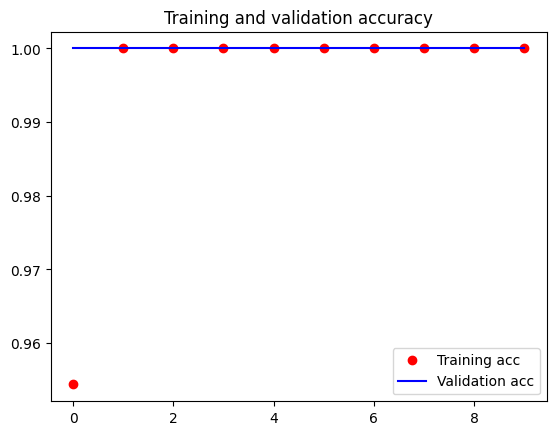

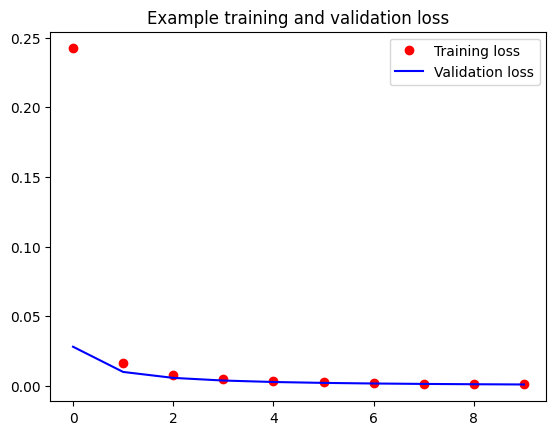

In [161]:
acc = history_model_1['accuracy']
val_acc = history_model_1['val_accuracy']
loss = history_model_1['loss']
val_loss = history_model_1['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

## Evaluating model_1

In [162]:
model_1.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 9.7299e-04 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 46996.6953 - tp: 0.0000e+00


[0.0009735625353641808, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85854.0, 0.0]

##Confusion Matrix

##Predictions

In [163]:
test_predictions = model_1.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
[[0.00062187 0.00085425 0.00107694 ... 0.00056285 0.00096765 0.00049877]
 [0.00064874 0.00089786 0.00112091 ... 0.00059046 0.00102029 0.00052801]
 [0.00062178 0.00085412 0.00107674 ... 0.00056276 0.00096749 0.00049869]
 ...
 [0.00062214 0.00085461 0.00107742 ... 0.00056308 0.00096808 0.00049898]
 [0.00064794 0.00089661 0.00111952 ... 0.00058957 0.00101857 0.00052712]
 [0.00062137 0.00085355 0.001076   ... 0.00056239 0.00096686 0.00049838]]


##Converting predictions to binary

In [164]:
binary_predictions = (test_predictions > 0.5).astype(int)

##Binary labels

In [167]:
def words_to_binary(word_labels, keywords):
  """
  Converts a list of word labels to binary labels.

  Args:
    word_labels: A list of lists, where each inner list contains indices of keywords present in a text.
    keywords: A list of keywords.

  Returns:
    A list of lists, where each inner list contains binary labels (1 if the keyword is present, 0 otherwise).
  """
  binary_labels = []
  for labels in word_labels:
    binary_row = [1 if i in labels else 0 for i in range(len(keywords))]
    binary_labels.append(binary_row)
  return binary_labels

list_of_texts_test = X_test

true_word_labels = create_labels(list_of_texts_test, keywords, tokenizer)
true_binary_labels = words_to_binary(true_word_labels, keywords,)
true_binary_labels_array = np.array(true_binary_labels)

##Creating confusion matrix

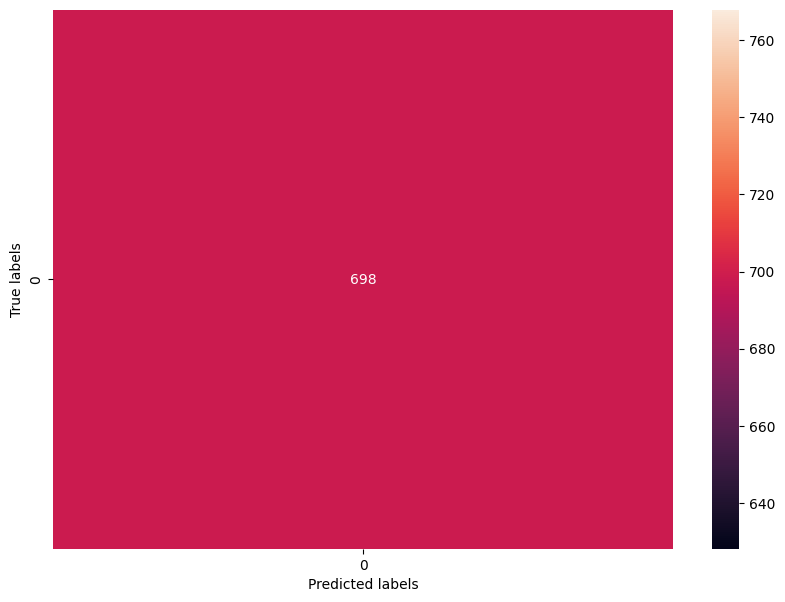

In [168]:
cm = confusion_matrix(true_binary_labels_array.argmax(axis=1), binary_predictions.argmax(axis=1))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Changing batch size

###Model 2

In [25]:
model_2 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])



##Compiling, training and saving the model

In [26]:
#Compiling the model
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_2 = model_2.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_2.save('model_2.keras')
with open('history_model_2.json', 'w') as f:
    json.dump(history_model_2.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9212 - auc: 0.7319 - fn: 4521.8359 - fp: 12066.8955 - loss: 0.4692 - precision: 0.0767 - recall: 0.1890 - tn: 201997.9375 - tp: 955.4776 - val_accuracy: 0.9769 - val_auc: 0.9191 - val_fn: 1653.0000 - val_fp: 334.0000 - val_loss: 0.0850 - val_precision: 0.5215 - val_recall: 0.1805 - val_tn: 83503.0000 - val_tp: 364.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9750 - auc: 0.9244 - fn: 3029.4031 - fp: 369.0000 - loss: 0.0838 - precision: 0.4874 - recall: 0.1200 - tn: 129949.8984 - tp: 339.8507 - val_accuracy: 0.9769 - val_auc: 0.9476 - val_fn: 1653.0000 - val_fp: 334.0000 - val_loss: 0.0715 - val_precision: 0.5215 - val_recall: 0.1805 - val_tn: 83503.0000 - val_tp: 364.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9745 - auc: 0.9457 - fn: 3109.6716 - fp: 318.0597 - loss: 0.0758 - precision: 0.5037 - recall: 0.1077 - tn: 129941.4141 - tp: 319.0000 - val_accuracy: 0.9769 - 

In [27]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model

In [28]:
model_2 = tf.keras.models.load_model('model_2.keras')
with open('history_model_2.json') as f:
    history_model_2 = json.load(f)

##Plotting the training history

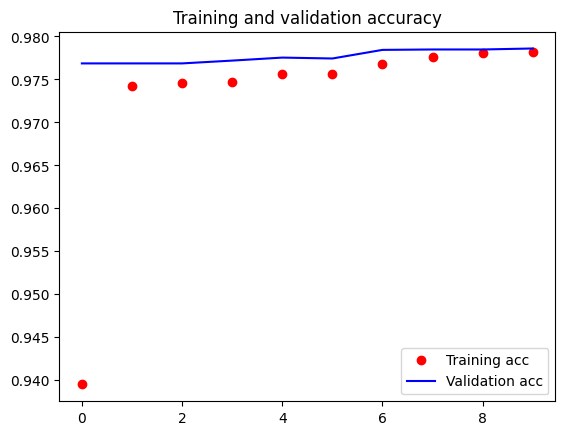

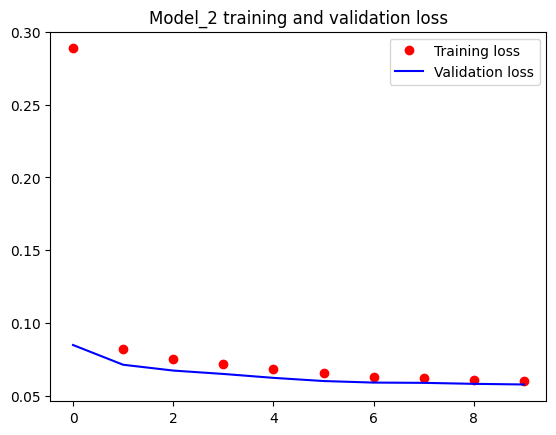

In [29]:
acc = history_model_2['accuracy']
val_acc = history_model_2['val_accuracy']
loss = history_model_2['loss']
val_loss = history_model_2['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model_2 training and validation loss')
plt.legend()

plt.show()

##Evaluting the model

In [30]:
model_2.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9785 - auc: 0.9652 - fn: 972.5217 - fp: 43.0870 - loss: 0.0574 - precision: 0.7576 - recall: 0.1160 - tn: 45839.4336 - tp: 141.6522


[0.05934750288724899,
 0.9776948094367981,
 0.761904776096344,
 0.14988289773464203,
 0.965412437915802,
 320.0,
 100.0,
 83619.0,
 1815.0]

##Predictions

In [31]:
test_predictions = model_2.predict(X_test)
print(test_predictions)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
[[0.00062664 0.0026392  0.01853721 ... 0.00088726 0.00037226 0.00459081]
 [0.00126098 0.00557938 0.0283946  ... 0.00096397 0.00097472 0.00976034]
 [0.00062682 0.00263979 0.01854123 ... 0.00088757 0.00037236 0.00459166]
 ...
 [0.00062703 0.00264051 0.01854532 ... 0.00088794 0.00037247 0.00459266]
 [0.00177523 0.02034626 0.03468076 ... 0.00116342 0.00186837 0.04329537]
 [0.00062583 0.00263668 0.01852562 ... 0.00088603 0.00037184 0.00458726]]


#Reduce number of LSTM modules

##Model 3

In [32]:
model_3 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(len(keywords), activation='sigmoid')
])



##Compiling, training and saving the model

In [33]:
#Compiling the model
model_3.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 17  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_3 = model_3.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_3.save('model_3.keras')
with open('history_model_3.json', 'w') as f:
    json.dump(history_model_3.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.8888 - auc: 0.7026 - fn: 4437.3281 - fp: 19579.3281 - loss: 0.5687 - precision: 0.0491 - recall: 0.1826 - tn: 194553.3438 - tp: 972.1492 - val_accuracy: 0.9768 - val_auc: 0.8011 - val_fn: 1979.0000 - val_fp: 12.0000 - val_loss: 0.1539 - val_precision: 0.7600 - val_recall: 0.0188 - val_tn: 83825.0000 - val_tp: 38.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9739 - auc: 0.8349 - fn: 3151.7463 - fp: 315.4478 - loss: 0.1343 - precision: 0.5685 - recall: 0.0919 - tn: 129871.6406 - tp: 349.3134 - val_accuracy: 0.9769 - val_auc: 0.9243 - val_fn: 1653.0000 - val_fp: 333.0000 - val_loss: 0.0911 - val_precision: 0.5222 - val_recall: 0.1805 - val_tn: 83504.0000 - val_tp: 364.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9740 - auc: 0.9197 - fn: 2939.6418 - fp: 482.9552 - loss: 0.0945 - precision: 0.5175 - recall: 0.1533 - tn: 129746.7500 - tp: 518.8060 - val_accuracy: 0.9765 - val

In [34]:
model_3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 1000, 64)            │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 123)                 │           4,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,006,931 (15.29 MB)

 Trainable params: 1,335,643 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,671,288 (10.19 MB)

##Reloading the model

In [35]:
model_3 = tf.keras.models.load_model('model_3.keras')
with open('history_model_3.json') as f:
    history_model_3 = json.load(f)

##Plotting the training history

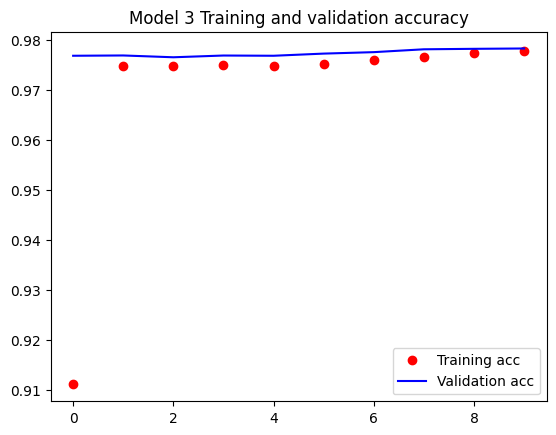

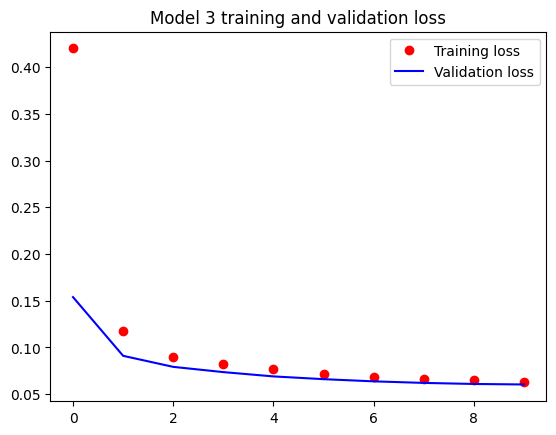

In [36]:
acc = history_model_3['accuracy']
val_acc = history_model_3['val_accuracy']
loss = history_model_3['loss']
val_loss = history_model_3['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 3 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 3 training and validation loss')
plt.legend()

plt.show()

##Evaluating the model

In [37]:
model_3.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9783 - auc: 0.9631 - fn: 1010.3043 - fp: 17.6957 - loss: 0.0598 - precision: 0.8280 - recall: 0.0872 - tn: 45864.8242 - tp: 103.8696


[0.06257198750972748,
 0.97739177942276,
 0.8674242496490479,
 0.10725995153188705,
 0.9626405239105225,
 229.0,
 35.0,
 83684.0,
 1906.0]

##Predictions

In [38]:
test_predictions = model_3.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
[[0.00422003 0.00706041 0.01592431 ... 0.00217358 0.00246435 0.00835023]
 [0.00648969 0.01023472 0.02456933 ... 0.00326661 0.0042233  0.01510008]
 [0.004214   0.00705207 0.01590817 ... 0.00216933 0.00246047 0.00834201]
 ...
 [0.00422467 0.0070662  0.01593664 ... 0.00217686 0.00246727 0.00835602]
 [0.00977951 0.01400475 0.0349825  ... 0.00442286 0.0077592  0.02413876]
 [0.00418935 0.00701801 0.01583637 ... 0.0021512  0.00244463 0.0083072 ]]


#Increasing batch size

##Model 4


In [39]:
model_4 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(len(keywords), activation='sigmoid')
])

##Compiling, training and saving the model

In [40]:
#Compiling the model
model_4.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_4 = model_4.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_4.save('model_4.keras')
with open('history_model_4.json', 'w') as f:
    json.dump(history_model_4.history, f)

model_4.summary()

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9016 - auc: 0.6898 - fn: 4775.6270 - fp: 16472.5527 - loss: 0.5502 - precision: 0.0352 - recall: 0.1096 - tn: 197727.1562 - tp: 566.8209 - val_accuracy: 0.9769 - val_auc: 0.8003 - val_fn: 1653.0000 - val_fp: 334.0000 - val_loss: 0.1528 - val_precision: 0.5215 - val_recall: 0.1805 - val_tn: 83503.0000 - val_tp: 364.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.9751 - auc: 0.8315 - fn: 2941.3433 - fp: 399.1194 - loss: 0.1316 - precision: 0.5032 - recall: 0.1374 - tn: 129940.7031 - tp: 406.9851 - val_accuracy: 0.9769 - val_auc: 0.9181 - val_fn: 1653.0000 - val_fp: 334.0000 - val_loss: 0.0925 - val_precision: 0.5215 - val_recall: 0.1805 - val_tn: 83503.0000 - val_tp: 364.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9748 - auc: 0.9188 - fn: 2919.2388 - fp: 449.6119 - loss: 0.0933 - precision: 0.4936 - recall: 0.1361 - tn: 129863.4453 - tp: 455.8507 - val_accuracy: 0.9768 - 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 1000, 64)            │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 123)                 │           4,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,006,931 (15.29 MB)

 Trainable params: 1,335,643 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,671,288 (10.19 MB)

##Reloading the model

In [41]:
model_4 = tf.keras.models.load_model('model_4.keras')
with open('history_model_4.json') as f:
    history_model_4 = json.load(f)

##Plotting the training history

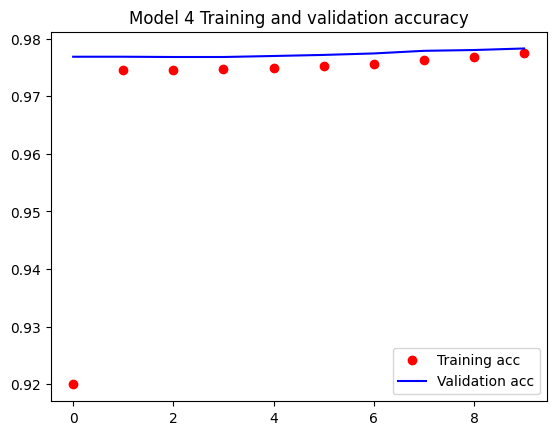

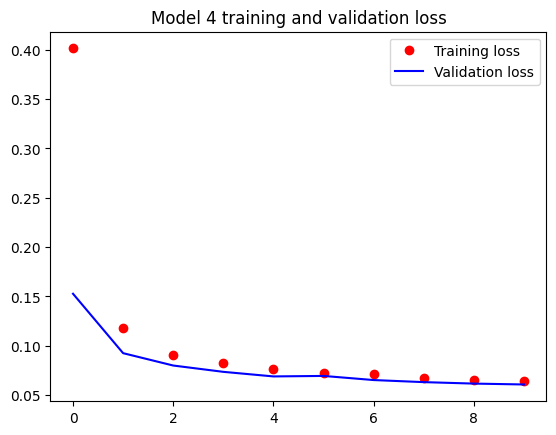

In [42]:
acc = history_model_4['accuracy']
val_acc = history_model_4['val_accuracy']
loss = history_model_4['loss']
val_loss = history_model_4['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 4 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 4 training and validation loss')
plt.legend()

plt.show()

##Evaluating the model

In [43]:
model_4.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9780 - auc: 0.9625 - fn: 1019.0870 - fp: 22.3478 - loss: 0.0606 - precision: 0.8020 - recall: 0.0807 - tn: 45860.1758 - tp: 95.0870


[0.06331510841846466,
 0.9770075678825378,
 0.8181818127632141,
 0.09695550054311752,
 0.9625730514526367,
 207.0,
 46.0,
 83673.0,
 1928.0]

##Predictions

In [44]:
test_predictions = model_4.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
[[0.00222134 0.00593659 0.01554298 ... 0.0033795  0.00233982 0.01221398]
 [0.00425275 0.01102868 0.0219425  ... 0.00401106 0.00407935 0.01941362]
 [0.00222402 0.00594102 0.0155557  ... 0.00338266 0.0023423  0.01222329]
 ...
 [0.00222894 0.00594848 0.0155769  ... 0.00338861 0.00234668 0.01223859]
 [0.0090837  0.04356065 0.04997513 ... 0.00963545 0.01121212 0.04974764]
 [0.00220484 0.00591022 0.01546891 ... 0.00335952 0.00232472 0.01215969]]


##Comparing the four models

In [45]:
model_1.evaluate(X_test, y_test)
model_2.evaluate(X_test, y_test)
model_3.evaluate(X_test, y_test)
model_4.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9790 - auc: 0.9631 - fn: 795.3043 - fp: 205.6087 - loss: 0.0574 - precision: 0.6084 - recall: 0.2835 - tn: 45676.9141 - tp: 318.8696
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9785 - auc: 0.9652 - fn: 972.5217 - fp: 43.0870 - loss: 0.0574 - precision: 0.7576 - recall: 0.1160 - tn: 45839.4336 - tp: 141.6522
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9783 - auc: 0.9631 - fn: 1010.3043 - fp: 17.6957 - loss: 0.0598 - precision: 0.8280 - recall: 0.0872 - tn: 45864.8242 - tp: 103.8696
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9780 - auc: 0.9625 - fn: 1019.0870 - fp: 22.3478 - loss: 0.0606 - precision: 0.8020 - recall: 0.0807 - tn: 45860.1758 - tp: 95.0870


[0.06331510841846466,
 0.9770075678825378,
 0.8181818127632141,
 0.09695550054311752,
 0.9625730514526367,
 207.0,
 46.0,
 83673.0,
 1928.0]

As can be see from the above the four models all perform very similarly however the more complex models of 1 and 2 have better loss functions.

For the next model I will change the loss function from binary crossentropy to hinge loss.
This should result encourage the model to not only make correct predictions but also be confident in those predictions

##Model 5

In [46]:
model_5 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])

##Compiling, training and saving the model

In [47]:
#Compiling the model
model_5.compile(
    loss = 'hinge',
    optimizer = 'adam',
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_5 = model_5.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_5.save('model_5.keras')
with open('history_model_5.json', 'w') as f:
    json.dump(history_model_5.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.9267 - auc: 0.6984 - fn: 4976.4478 - fp: 10464.2539 - loss: 1.3193 - precision: 0.0397 - recall: 0.0868 - tn: 203688.1094 - tp: 413.3433 - val_accuracy: 0.9765 - val_auc: 0.6544 - val_fn: 2017.0000 - val_fp: 0.0000e+00 - val_loss: 1.0203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83837.0000 - val_tp: 0.0000e+00
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9737 - auc: 0.6326 - fn: 3471.9402 - fp: 0.0000e+00 - loss: 1.0148 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 130216.2109 - tp: 0.0000e+00 - val_accuracy: 0.9765 - val_auc: 0.6486 - val_fn: 2017.0000 - val_fp: 0.0000e+00 - val_loss: 1.0070 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83837.0000 - val_tp: 0.0000e+00
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9746 - auc: 0.6140 - fn: 3388.4329 - fp: 0.0000e+00 - loss: 1.0061 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 13029

In [48]:
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model

In [49]:
model_5 = tf.keras.models.load_model('model_5.keras')
with open('history_model_5.json') as f:
    history_model_5 = json.load(f)

##Plotting the training

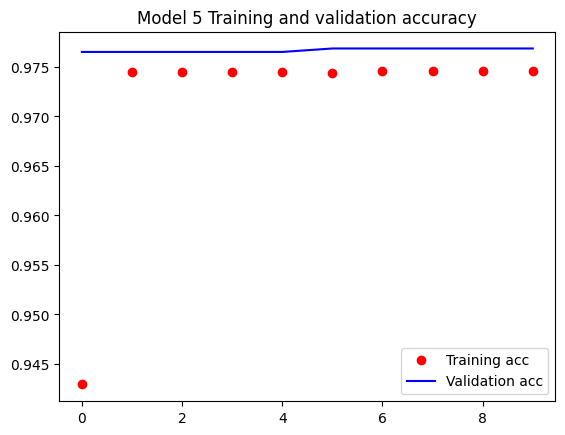

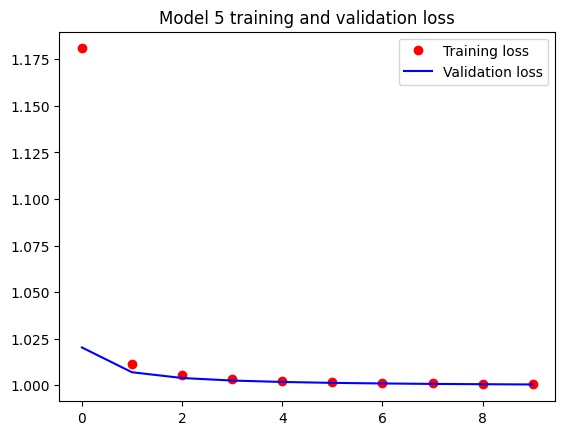

In [50]:
acc = history_model_5['accuracy']
val_acc = history_model_5['val_accuracy']
loss = history_model_5['loss']
val_loss = history_model_5['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 5 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 5 training and validation loss')
plt.legend()

plt.show()

##Evaluating the model

In [51]:
model_5.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9772 - auc: 0.5916 - fn: 911.4348 - fp: 179.3478 - loss: 1.0002 - precision: 0.5373 - recall: 0.1871 - tn: 45703.1758 - tp: 202.7391


[1.0004407167434692,
 0.9754582643508911,
 0.5200573205947876,
 0.17002342641353607,
 0.5830109715461731,
 363.0,
 335.0,
 83384.0,
 1772.0]

##Predictions

In [52]:
test_predictions = model_5.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
[[0.00042298 0.00064953 0.00040182 ... 0.00045771 0.00087676 0.00085048]
 [0.00044226 0.0006725  0.00041697 ... 0.00047398 0.00090372 0.00088848]
 [0.00042297 0.00064953 0.00040182 ... 0.00045772 0.00087673 0.00085048]
 ...
 [0.00042303 0.00064962 0.00040187 ... 0.00045778 0.00087684 0.00085057]
 [0.00044233 0.00067264 0.00041708 ... 0.00047406 0.0009039  0.00088868]
 [0.00042264 0.00064903 0.00040146 ... 0.00045731 0.00087604 0.00084998]]


##Model 6 - training for 20 epochs

In [53]:
model_6 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])

##Compiling, training and saving the model

In [54]:
#Compiling the model
model_6.compile(
    loss = 'hinge',
    optimizer = 'adam',
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_6 = model_6.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 20,

)

#Saving the model
model_6.save('model_6.keras')
with open('history_model_6.json', 'w') as f:
    json.dump(history_model_6.history, f)

model_6.summary()

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.9036 - auc: 0.5910 - fn: 4544.7461 - fp: 15811.5820 - loss: 1.3332 - precision: 0.0548 - recall: 0.1684 - tn: 198301.1719 - tp: 884.6418 - val_accuracy: 0.9765 - val_auc: 0.5967 - val_fn: 2017.0000 - val_fp: 0.0000e+00 - val_loss: 1.0208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83837.0000 - val_tp: 0.0000e+00
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9760 - auc: 0.5967 - fn: 3301.4031 - fp: 0.0000e+00 - loss: 1.0152 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 130386.7500 - tp: 0.0000e+00 - val_accuracy: 0.9765 - val_auc: 0.5882 - val_fn: 2017.0000 - val_fp: 0.0000e+00 - val_loss: 1.0069 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83837.0000 - val_tp: 0.0000e+00
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9739 - auc: 0.5791 - fn: 2978.8508 - fp: 466.4627 - loss: 1.0061 - precision: 0.4508 - recall: 0.1130 - tn: 129789.4922 - t

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model

In [55]:
model_6 = tf.keras.models.load_model('model_6.keras')
with open('history_model_6.json') as f:
    history_model_6 = json.load(f)

##Training plots

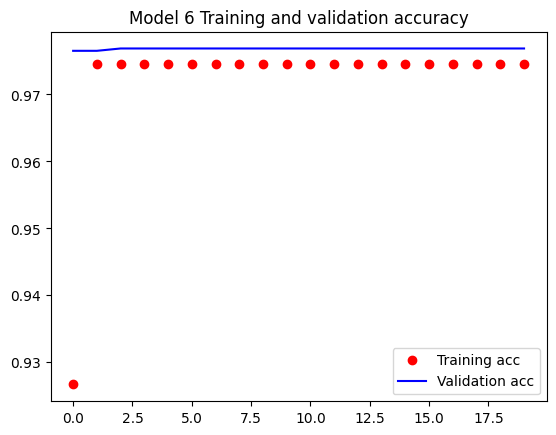

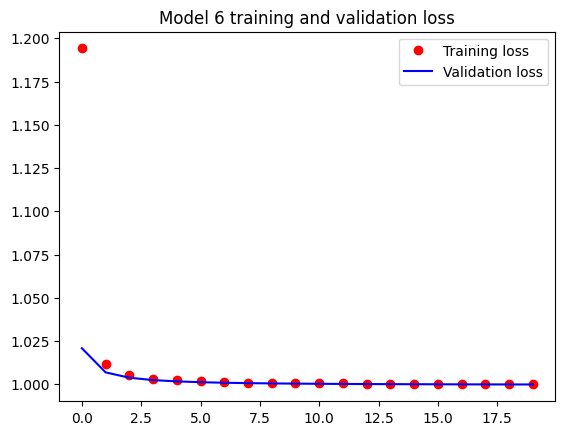

In [56]:
acc = history_model_6['accuracy']
val_acc = history_model_6['val_accuracy']
loss = history_model_6['loss']
val_loss = history_model_6['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 6 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 6 training and validation loss')
plt.legend()

plt.show()

##Predictions

In [57]:
test_predictions = model_6.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
[[0.00016212 0.00032296 0.00023154 ... 0.0002042  0.0001203  0.00026618]
 [0.00016913 0.00033429 0.00023982 ... 0.00021091 0.00012496 0.0002781 ]
 [0.00016208 0.00032289 0.00023148 ... 0.00020415 0.00012027 0.00026612]
 ...
 [0.0001622  0.00032309 0.00023164 ... 0.00020429 0.00012035 0.00026628]
 [0.00016912 0.00033426 0.00023983 ... 0.0002109  0.00012495 0.00027809]
 [0.00016189 0.00032255 0.00023122 ... 0.0002039  0.00012013 0.00026585]]


##Evaluating the model

In [58]:
model_6.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9772 - auc: 0.5916 - fn: 911.4348 - fp: 179.3478 - loss: 0.9996 - precision: 0.5373 - recall: 0.1871 - tn: 45703.1758 - tp: 202.7391


[0.9999067187309265,
 0.9754582643508911,
 0.5200573205947876,
 0.17002342641353607,
 0.5830109715461731,
 363.0,
 335.0,
 83384.0,
 1772.0]

Accuracy of models 5 and 6 similiar to all other models

##Model 7 Changing loss function to categorical crossentropy

##One hot encoding the labels

##Building the model

In [91]:
model_7 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    # Calculate the correct output shape for the Reshape layer
    Reshape((-1, 64 * 2)),  # 64 LSTM units * 2 for Bidirectional
    Dense(num_keywords, activation='softmax')  # Add a Dense layer for classification
])

## compiling the model

In [103]:
model_7.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = METRICS
)




## Training and saving the model

In [120]:
# Extract individual words, removing padding tokens
words = []
for sequence in padded_sequences:
    words.extend([word for word in sequence if word != 0])

# Create a new X_train with one row per word
X_train_words = np.array(words).reshape(-1, 1)  # Reshape to 2D array

# Flatten y_train to have one label per word
y_train_flat = []
for text_labels, sequence in zip(y_train, padded_sequences):
    for label, word_index in zip(text_labels, sequence):
        if word_index != 0:  # Only include labels for non-padding tokens
            y_train_flat.append(label)

y_train_flat = np.array(y_train_flat).reshape(-1, 1)
print("Shape of X_train_words:", X_train_words.shape)
print("Shape of y_train_flat:", y_train_flat.shape)

Shape of X_train_words: (1306801, 1)
Shape of y_train_flat: (25603, 1)


In [121]:
# Calculate the correct number of samples
num_samples_train = y_train_encoded.shape[0]
num_samples_val = y_val_encoded.shape[0]

# Reshape y_train_encoded to match the expected output shape (num_samples, 1, 2)
y_train_reshaped = y_train_encoded.reshape(num_samples_train, 1, 2)
y_val_reshaped = y_val_encoded.reshape(num_samples_val, 1, 2)  # Adjust y_val_encoded similarly


#Training the model
try:
    #Training the model
    model_7 = model_7.fit(
        X_train_words, y_train_flat,
        validation_data=(X_val, y_val_reshaped),
        epochs=10
    )
except ValueError as e:
    print("ValueError occurred:", e)  # Print the full error message
#Saving the model
model_7.save('model_7.keras')
with open('history_model_7.json', 'w') as f:
    json.dump(history_model_7.history, f)

model_7.summary()

ValueError occurred: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1306801
'y' sizes: 25603



NameError: name 'history_model_7' is not defined